Generating predictions for test set...


100%|██████████| 95/95 [02:05<00:00,  1.32s/it]


Mean of ground truth LFP (after z-scoring): [ 0.00423978  0.00348998  0.0025337   0.00254349  0.00235781  0.00391351
  0.00658366  0.00115176  0.00224883  0.00454291  0.00453614  0.00192753
  0.00302257  0.00307432  0.00396607  0.0036808   0.00524049  0.0021689
  0.00237448  0.00328057  0.00264863  0.00376922  0.0020229   0.00263676
  0.00222433  0.00619075  0.00379494  0.00401977  0.00389489  0.0042256
  0.00336311  0.00323173  0.00351664  0.00345104  0.00432461  0.00352999
  0.00401679  0.00310769  0.00486776  0.00368628  0.00230889  0.000487
  0.00068497  0.00049985  0.00088269  0.00178247  0.00218687  0.0029838
  0.00266442  0.00265771  0.00169877  0.00236844  0.00101383  0.00093622
 -0.00065144 -0.00219436 -0.00358978 -0.00215088 -0.00172052 -0.00234886
  0.00278665  0.00051057 -0.00112028 -0.00220208 -0.00106975 -0.00107512
 -0.00089007 -0.00063731  0.00137808 -0.00187843 -0.00086651 -0.00128899
 -0.00183739 -0.00229887 -0.00105137 -0.00222623 -0.00355366 -0.00236578
 -0.00212002

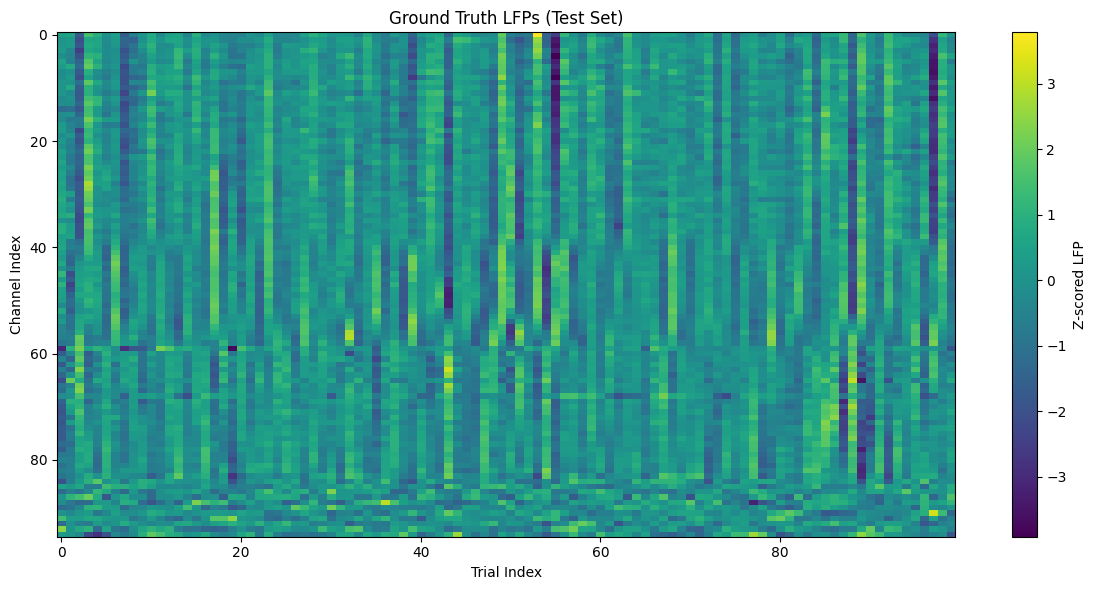

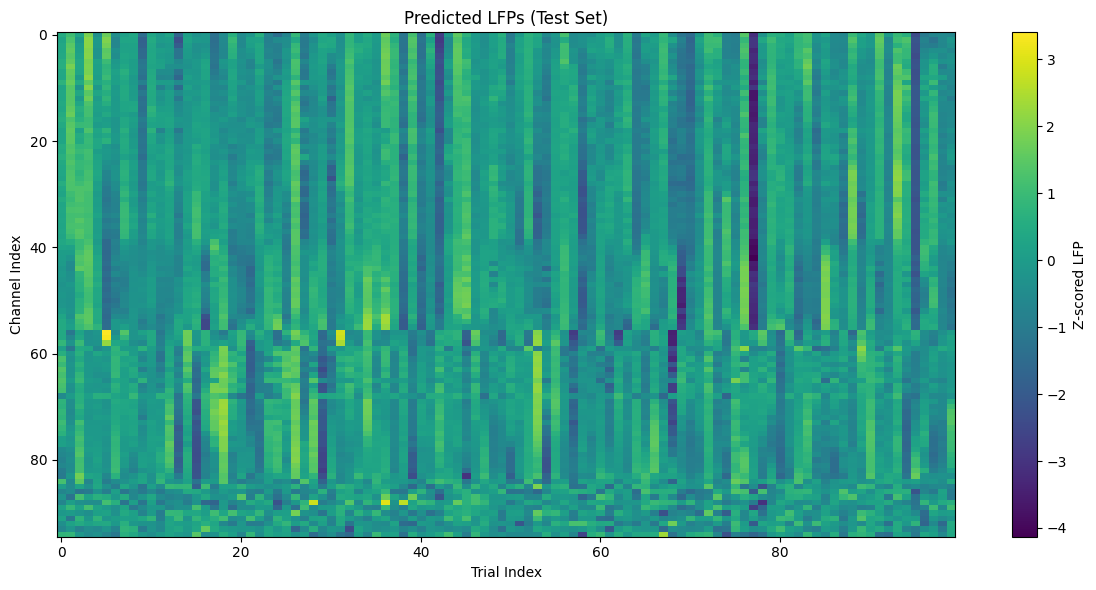

In [2]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from dotenv import load_dotenv
# Load environment variables
load_dotenv()

# === Load test data ===
cache_path = os.environ.get("RAINBOW_MOUSE_CACHE")
lfp = np.load(f"{cache_path}/lfp_X.npy")         # [95, 118*50]
frames = np.load(f"{cache_path}/lfp_y.npy") - 1   # [5900], now 0–117
vit_embeddings = np.load(f"{cache_path}/vit_embeddings.npy")  # [118, 192]

# Split train/test
lfp_train = lfp[:, :118*30]
lfp_test = lfp[:, 118*30:]
frames_train = frames[:118*30]
frames_test = frames[118*30:]

# Z-score using train stats
lfp_mean = np.mean(lfp_train, axis=1, keepdims=True)
lfp_std = np.std(lfp_train, axis=1, keepdims=True)

lfp_train = (lfp_train - lfp_mean) / lfp_std
lfp_test = (lfp_test - lfp_mean) / lfp_std

# === Load trained attention model ===
from rainbow_mouse.models.attention import CausalLFPTransformer  # adjust path as needed

device = "cuda" if torch.cuda.is_available() else "cpu"
model = CausalLFPTransformer().to(device)
model.load_state_dict(torch.load(f"{cache_path}/lfp_model_attention.pth"))
model.eval()

# === Define parameters ===
window_size = model.window_size
half_window = window_size // 2
n_channels, n_trials = lfp_test.shape

# === Generate predictions ===
lfp_preds = np.zeros((n_channels, n_trials - window_size + 1))  # output is smaller due to window

print("Generating predictions for test set...")

for channel in tqdm(range(n_channels)):
    for t in range(half_window, n_trials - half_window):
        frame_window = frames_test[t - half_window : t + half_window + 1]  # [window_size]
        vit_window = vit_embeddings[frame_window]                          # [window_size, 192]
        vit_window_tensor = torch.tensor(vit_window, dtype=torch.float32).unsqueeze(0).to(device)  # [1, T, 192]
        channel_tensor = torch.tensor([channel], dtype=torch.long).to(device)

        with torch.no_grad():
            pred = model(vit_window_tensor, channel_tensor).cpu().item()

        lfp_preds[channel, t - half_window] = pred  # adjust index to match reduced output size

# === Plotting ===
def plot_lfp_heatmap(data, title):
    plt.figure(figsize=(12, 6))
    plt.imshow(data, aspect='auto', cmap='viridis', interpolation='none')
    plt.colorbar(label='Z-scored LFP')
    plt.title(title)
    plt.xlabel("Trial Index")
    plt.ylabel("Channel Index")
    plt.tight_layout()
    plt.show()
    
# Clip to same size for visual match
aligned_lfp_test = lfp_test[:, half_window : -half_window]

print("Mean of ground truth LFP (after z-scoring):", aligned_lfp_test.mean(axis=1))
plot_lfp_heatmap(aligned_lfp_test[:, :100], "Ground Truth LFPs (Test Set)")
plot_lfp_heatmap(lfp_preds[:, :100], "Predicted LFPs (Test Set)")


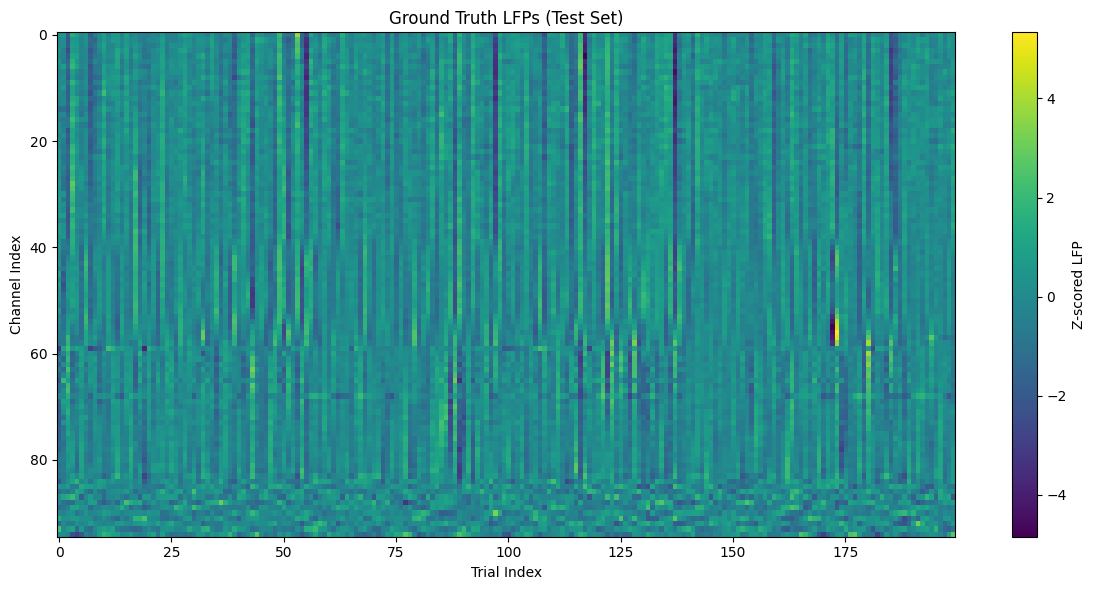

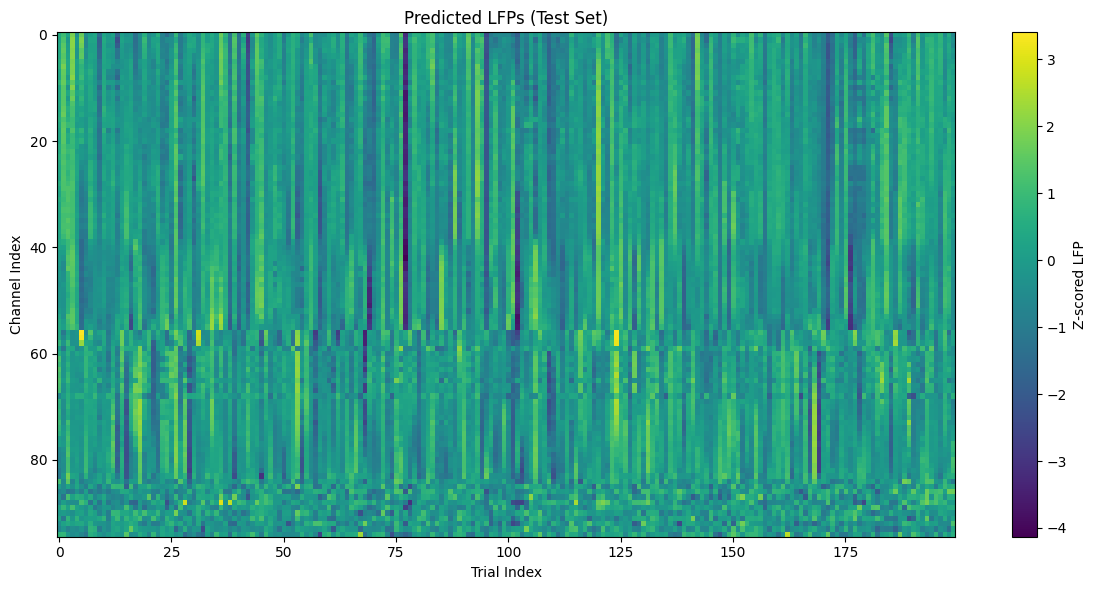

In [3]:
plot_lfp_heatmap(aligned_lfp_test[:, :200], "Ground Truth LFPs (Test Set)")
plot_lfp_heatmap(lfp_preds[:, :200], "Predicted LFPs (Test Set)")


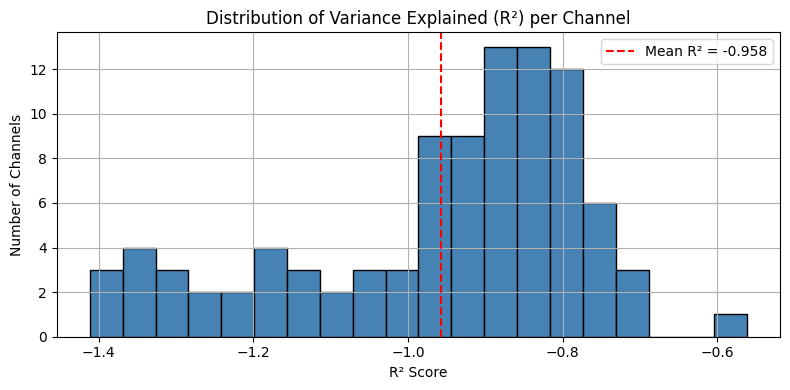

In [4]:
# === Compute variance explained per channel ===
r2_scores = []
for c in range(n_channels):
    y_true = aligned_lfp_test[c]
    y_pred = lfp_preds[c]
    
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    
    r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0.0
    r2_scores.append(r2)

r2_scores = np.array(r2_scores)

# === Plot histogram of R² across channels ===
plt.figure(figsize=(8, 4))
plt.hist(r2_scores, bins=20, color='steelblue', edgecolor='black')
plt.axvline(np.mean(r2_scores), color='red', linestyle='--', label=f"Mean R² = {np.mean(r2_scores):.3f}")
plt.title("Distribution of Variance Explained (R²) per Channel")
plt.xlabel("R² Score")
plt.ylabel("Number of Channels")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Generating predictions for training set...


100%|██████████| 95/95 [03:24<00:00,  2.15s/it]


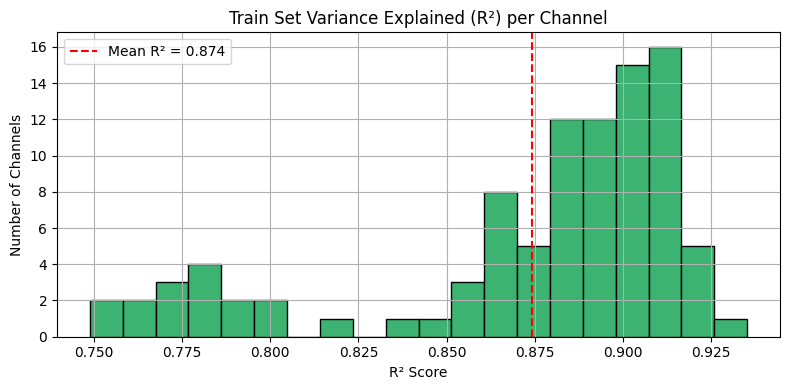

In [5]:
# === Generate predictions for training set ===
n_channels, n_train_trials = lfp_train.shape
train_preds = np.zeros((n_channels, n_train_trials - window_size + 1))

print("Generating predictions for training set...")

for channel in tqdm(range(n_channels)):
    for t in range(half_window, n_train_trials - half_window):
        frame_window = frames_train[t - half_window : t + half_window + 1]  # [window_size]
        vit_window = vit_embeddings[frame_window]                          # [window_size, 192]
        vit_window_tensor = torch.tensor(vit_window, dtype=torch.float32).unsqueeze(0).to(device)  # [1, T, 192]
        channel_tensor = torch.tensor([channel], dtype=torch.long).to(device)

        with torch.no_grad():
            pred = model(vit_window_tensor, channel_tensor).cpu().item()

        train_preds[channel, t - half_window] = pred

# Align shapes
aligned_lfp_train = lfp_train[:, half_window : -half_window]

# === Compute variance explained per channel (train set) ===
train_r2_scores = []
for c in range(n_channels):
    y_true = aligned_lfp_train[c]
    y_pred = train_preds[c]
    
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    
    r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0.0
    train_r2_scores.append(r2)

train_r2_scores = np.array(train_r2_scores)

# === Plot histogram of R² on train set ===
plt.figure(figsize=(8, 4))
plt.hist(train_r2_scores, bins=20, color='mediumseagreen', edgecolor='black')
plt.axvline(np.mean(train_r2_scores), color='red', linestyle='--', label=f"Mean R² = {np.mean(train_r2_scores):.3f}")
plt.title("Train Set Variance Explained (R²) per Channel")
plt.xlabel("R² Score")
plt.ylabel("Number of Channels")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
